# Latent Dirichlet Allocation
Michael Fitzke, 2016

In [1]:
%pylab inline
import numpy 
import matplotlib.pylab as plt 

Populating the interactive namespace from numpy and matplotlib


Latent Dirichlet Allocation (LDA) is a Generative Bayesian Model or Graphical Model. That means the observable data is thought of to be generated by some hidden variables. 

In [2]:
# We have to set some hyper-parameters first

# Number of Topics: 
K = 3
#prior weight of topic k in a document
alpha = np.array([0.1, 0.1, 0.1])
# prior weight of word w in a topic ( we assume only 8 "Words" 1, 2, 3, 4, 5, 6, 7, 8)
beta = np.array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

### Step 1
In LDA documents are seen as bags-of-words which are generated by the following process: <br />
for $i \in 1 \ldots K$: <br />
choose 

In [3]:
topics = []
for i in range(K):
    topics.append(np.random.dirichlet(beta))

A topic in this scence is nothing more than a **random distribution over words** 
Let's take a look on the first topic:  

In [4]:
topics[0]

array([  1.20225140e-10,   7.67376118e-04,   9.33515878e-05,
         1.17062828e-01,   8.61929229e-02,   8.37110415e-07,
         2.46800343e-03,   7.93414681e-01])

<Container object of 8 artists>

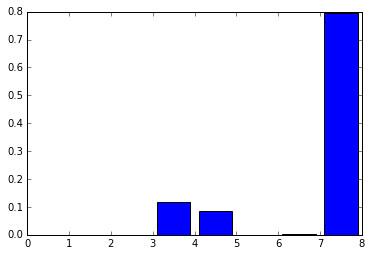

In [5]:
ind = np.arange(8) 
width = 0.1
plt.bar(ind+width, topics[0])

### Step 2
Let's make a Document. <br />
For each Document we choose from another Dirichlet to mix our topics: 


In [6]:
doc1_topic_distribution = np.random.dirichlet(alpha)

Let's check this out, too: 

In [7]:
doc1_topic_distribution

array([ 0.02791128,  0.96127331,  0.01081541])

Now, for each word $N_i$ in our Document, we choose a topic from a multinomial that is parameterized by our dirichlet: 

In [8]:
top = np.random.multinomial(1, doc1_topic_distribution)

In [9]:
top

array([0, 1, 0])

Then we choose the topic that the multinomial has given us and use our other dirichlet for a multinomial that generates the words: 

In [10]:
this_topic = topics[np.argmax(top)]

In [11]:
word = np.random.multinomial(1, this_topic)

In [12]:
word

array([0, 0, 0, 1, 0, 0, 0, 0])

By this process our first word is:

In [13]:
str(np.argmax(word) + 1)

'4'

The whole process to create a document with length N looks like this: 

In [14]:
def make_document(N = 30, topic_dist = None):
    if topic_dist == None:
        topic_dist = np.random.dirichlet(alpha)
    my_doc = ""
    for i in range(N):
        top = np.random.multinomial(1, topic_dist)
        this_topic = topics[np.argmax(top)]
        word = np.random.multinomial(1, this_topic)
        my_doc += str(np.argmax(word) + 1)
        my_doc += " "
    return my_doc

<img src="http://mengjunxie.github.io/ae-lda/img/IntroToLDA.png" width="66%">

In [15]:
make_document(topic_dist = doc1_topic_distribution)

C:\Users\mfitzke\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


'6 6 1 6 6 1 6 6 6 1 6 5 6 6 3 3 6 1 3 6 6 1 6 6 6 4 6 6 6 3 '

For each document another random varable is drawn from the dirichlet to model the topic distribution of that document. 
In plate notation the graphical model that we just coded looks like this: 

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Smoothed_LDA.png" width="66%">

Where
- $M$ is the number of documents in the corpus
- $K$ is the number of topics
- $N$ is the number of words per document
- $\alpha$ is the parameter for the topic distribution per document
- $\Theta$ is a dirichlet rv, topic distribution per document
- $Z$ is a multinomial rv, the identity of the topic per word 
- $W$ is the actual word, could be represented as an integer $W \in \{1, \ldots, V\}$ where $V$ is the size of the dictonary 
- $\beta$ is the parameter of the topic (distribution over words)
- $\varphi$ is a dirichlet rv, the topic, i.e a distribution over all words in the dictionary 

Learning the different distributions is a problem of Bayesian inference. It can be approximated with Gibbs Sampling (MCMC). 

## Let's make a corpus

In [16]:
corpus = []
N = 30
for i in range(200): 
    topic_dist = np.random.dirichlet(alpha)
    document = zeros(8)
    for i in range(N):
        top = np.random.multinomial(1, topic_dist)
        this_topic = topics[np.argmax(top)]
        word = np.random.multinomial(1, this_topic)
        document += word
    corpus.append(document)
corpus = np.array(corpus, dtype=int64)
corpus

array([[ 0,  0,  0, ...,  0,  1, 24],
       [ 0,  0, 20, ...,  4,  1,  4],
       [ 0,  0,  0, ...,  0,  0, 26],
       ..., 
       [ 2,  0,  4, ..., 24,  0,  0],
       [ 0,  0, 24, ...,  6,  0,  0],
       [ 2,  0,  1, ..., 16,  0, 11]], dtype=int64)

## Inference
We will try to discover the real topics. We'll use the package lda for this task, that uses collapsed Gibbs Sampling to discover the distributions. 

In [17]:
import lda
model = lda.LDA(n_topics=3, n_iter=1500, random_state=42)
model.fit(corpus)

<lda.lda.LDA instance at 0x0000000006478688>

In [18]:
topic_word = model.topic_word_ 
ind = np.arange(8) 
width = 0.1

<Container object of 8 artists>

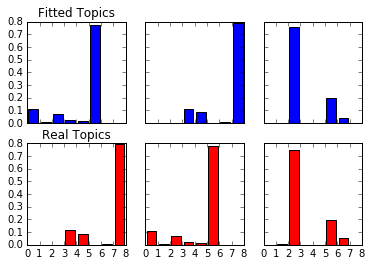

In [19]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
ax1.bar(ind+width, topic_word[0])
ax1.set_title('Fitted Topics')
ax2.bar(ind+width, topic_word[1])
ax3.bar(ind+width, topic_word[2])
ax4.set_title('Real Topics')
ax4.bar(ind+width, topics[0], color ="r")
ax5.bar(ind+width, topics[1], color ="r")
ax6.bar(ind+width, topics[2], color="r")

Of course that's a toy example where we generated the data exactly in the way LDA expects us to. Let's take a look on some of the Topics LDA discovered in a real data set. That is the (in)famous Enron corpus that consits of >250.000 E-Mails. We used LDA rather naively in this case by setting 100 topics without parameter tuning and just removing a couple of stop words.

These examples of different topics are showing the 14 words with the highest probability in each topic. 
- Topic 4: fantasy sportsline mp league random he com owner script players key week game elink
- Topic 12: said the power enron company india project government with was state dabhol dpc be
- Topic 13: power california prices market price the energy said electricity state iso was at ferc
- Topic 22: credit market bank no the financial investment area debt risk rating cash with be
- Topic 24: this the be risk data with we have will model report value each all


## References
 
 
- Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent Dirichlet Allocation." Journal of Machine Learning Research 3 (2003): 993–1022. 

- Griffiths, Thomas L., and Mark Steyvers. "Finding Scientific Topics." Proceedings of the National Academy of Sciences 101 (2004): 5228–5235. doi:10.1073/pnas.0307752101. 

- Wallach, Hanna, David Mimno, and Andrew McCallum. "Rethinking LDA: Why Priors Matter." In Advances in Neural Information Processing Systems 22, edited by Y.  Bengio, D. Schuurmans, J. Lafferty, C. K. I. Williams, and A.Culotta, 1973–1981, 2009. 

- Buntine, Wray. "Estimating Likelihoods for Topic Models." In Advances in Machine Learning, First Asian Conference on Machine Learning (2009): 51–64. doi:10.1007/978-3-642-05224-8_6. 
